# loop data handling and processing

### *the code below helps calculate the daily, hourly average traffic volume based on the given data (collected from WSDOT loop: https://tracflow.wsdot.wa.gov/contourdata/brainscan)*

## We separate the code into three parts for sharing
### 1. Needed packages 
### 2. Utility functions
### 3. Examples  da

## 1. Needed packages

In [1]:
import pandas as pd
from pandas import *
import numpy as np
import os
from datetime import *
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import csv
from zipfile import ZipFile
from matplotlib.pyplot import figure
import matplotlib

## 2. Utility functions
After you download the data from WSDOT loop, you will receive some zip files the function below helps you unzip the file, check if the loop encounter with a large number of missing data issues based on your interested date period, and keep the .xlsx file only.
Note: The volume sheet under the excel file should look like below:
column should follow: year-month-day hour:minute:second,
row (here we use hourly average) should follow: hour:minute:second

- input: 
    - filepath: file path you store the zip file 
    - date1: start date 
    - date2: end date
- output: 
    - .xlsx files from the zip file which have data based on your given date period
    - Calculated daily, hourly traffic volume and its corresponding plot

In [12]:
# the detailed data format is shown below

In [2]:
dt = pd.read_excel("../acbcao/005es16237_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx", sheet_name="Volume",index_col=0)
dt.head()

,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,...,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31
00:00:00,1309,1481,1180,1058,881,852,912,1509,1560,1018.0,...,1076,-1,1640,1405,1052.0,1095,1038,1159,1596,1644
01:00:00,868,948,741,727,645,618,647,945,949,615.0,...,738,-1,1018,618,681.0,679,750,688,945,1017
02:00:00,680,278,595,617,619,545,669,756,784,580.0,...,717,-1,782,671,672.0,626,677,726,766,759
03:00:00,700,-5,1083,1081,1067,1127,1149,809,595,1170.0,...,1353,-1,642,1245,1268.0,1302,1241,1255,768,643
04:00:00,1224,-5,3061,3096,3109,3116,3280,1431,916,3721.0,...,3436,-1,911,3523,3423.0,3494,3460,3337,1256,914


In [3]:
# unzip the file and process the data
def raw_data_process(filepath, date1, date2):
    # get all the files under the given path
    folders = os.listdir(filepath)
    # check the zip file and unzip them all
    for i in folders:
        if i[-3:] == 'zip':
            zip = ZipFile(filepath+i)
            zip.extractall(path=filepath)

    files = os.listdir(filepath)
    # get current xlsx file and remove the .png file  
    dtfiles = []
    index = 0
    for i in files:
        if i[-4:] == 'xlsx':
            dtfiles.append(filepath+i)
        if i[-3:] == 'png':
            os.remove(filepath+i)
        # if other files detected, print a caution, the other files which not directly
        # from the folder may cause some error for the other function
        # set up an index to detect such situation to avoid repeated print
        elif index == 0 and i[:-4]!='xlsx' and i[-3:]!='png':
                print('Caution: there are other files detected except the zipped file in the given folder')
                print('Warning: other files may cause error for other functions')
                index = index + 1
                      
            
    # check data and delete .xlsx fle with missing data only with the period you are interested
    for excel in dtfiles:
        dt = pd.read_excel(excel, sheet_name='Volume', index_col=0)
        col =  list(dt.columns)
        a = 0 
        for coln in col:
            try:
                if datetime.strptime(str(coln),'%Y-%m-%d %H:%M:%S') >= date1 and datetime.strptime(str(coln),'%Y-%m-%d %H:%M:%S') <= date2:
                    a = a+sum(dt[coln])
            except:
                print('Colume format error, check if colume name follows date format: year-month-day hour:minute:second')
        if a < 0:
            os.remove(excel)

# data processing
# here we tide the data into ditrect format
# the output looks like {loopid:{time period:{datetime:[vol]}}} where vol is ordered by hour
# e.g., {'005es16186_MN':'BC':datetime(2019,1,5,0,0):[100, 200, 300,...]}
# create the dict followed by the format
def makeloopvol(periodlst, pathfile):  
    # get current pathfile
    dtfiles = get_datafile(pathfile)
    print(dtfiles)
    loop_vol = {}
    for excel in dtfiles:
        # get the index of loop id from the .xlsx path
        # the excel name should look similar as th eformat below:
        # "005es16186_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx"
        # the loop id looks like 005es16186_MN where 005 is the route, 16186 is the milepost for the loops
        # MN is the direction, in this example, MN stands form North bound
        # here we call getloopidindex to locate the loopid based on its excel path
        index1,index2 = getloopidindex(excel)
        loop_vol[excel[index1:index2]] = {}
        for period in periodlst:
            loop_vol[excel[index1:index2]][period] = {}
    return(loop_vol)

def getloopidindex(excel_path):
    direction = ['MN_', 'MS_', 'MW_', 'ME_']
    for direct in direction:
        if direct in excel_path:
            index = excel_path.index(direct[1:])
            # return the location of the loopid based on the excel path string
            # 12 is the length of the loopid, e.g., 005es16186_MN
            return(index-12, index+1)
            break  

# get current .xlsx in the folder
def get_datafile(pathfile):
    files = os.listdir(pathfile)
    dtfiles = []
    for i in files:
        if i[-4:] == 'xlsx' and i[0]!='~':
            dtfiles.append(pathfile+i)
    return(dtfiles)

# if negative value is found for volume (regarding as missing value), convert them to zero
def convert_negative_val(lst):
    a = 0
    tup = np.nonzero(lst)
    for i in tup:
        cklst = i
    for i in range(len(lst)):
        if lst[i] < 0:
            lst[i] = 0
    return(lst)

# get loop volume
def get_loop(t1, t2, dt, day, period, loopid, loop_vol, date):                    
    if date >= t1 and date <= t2:
        volst = convert_negative_val(list(dt[day]))
        if volst != None:
            loop_vol[loopid][period][date] = []
            loop_vol[loopid][period][date] = volst
    return(loop_vol)
            
def excel_processing(pathfile, periodlst, time_bond, loop_vol):
    dtfiles = get_datafile(pathfile)
    for excel in dtfiles:
        dt = pd.read_excel(excel, sheet_name='Volume', index_col=0)
        # get the index of loop id from the .xlsx path
        index1,index2 = getloopidindex(excel)
        loopid = excel[index1:index2]
        daylst = list(dt.columns)
        hourlst = list(dt.index)
        # check data availability during befor closure period
        for day in daylst:
            date = datetime.strptime(str(day),'%Y-%m-%d %H:%M:%S')
            loop_vol = get_loop(time_bond[0], time_bond[1], dt, day, periodlst[0], loopid, loop_vol, date)
            loop_vol = get_loop(time_bond[2], time_bond[3], dt, day, periodlst[1], loopid, loop_vol, date)
            loop_vol = get_loop(time_bond[4], time_bond[5], dt, day, periodlst[2], loopid, loop_vol, date)
    return(loop_vol)

#get latitude and longitude for each loop
def get_loop_location(loopvol, pathfile):
    dtfiles = get_datafile(pathfile)
    # create a loc direct to stire lat, lon for each loop id
    loc = {}
    for i in loopvol:
        loc[i] = []
    for j in dtfiles:
        dt = pd.read_excel(j, sheet_name='Metadata')
        index1,index2 = getloopidindex(j)
        loc[j[index1:index2]] = list(dt.iloc[0][1:])
    return(loc)

# calculate the value
# calculate daily average by loop within a week (by day, mor_peak, eve_peak)
# calculate daily average (by Sat, Sun, Mon,...) by day
def CalVol(loopvoldict, t1, t2, d1, d2):
    wkavg_loop = {}
    davg_loop = {} 
    for lpid in loopvoldict:
        # create dict to store daily and weekly average
        wkavg_loop[lpid] = {}
        davg_loop[lpid] = {}
        pdlst = list(loopvoldict[lpid].keys())
        for pd in pdlst:
            wkavg_loop[lpid][pd] = 0
            davg_loop[lpid][pd] = {}
            date_time = list(loopvoldict[lpid][pd].keys())
            # call the CalWeekAvg function to calculate the weekday traffic volume average for each loop id
            wkavg_loop[lpid][pd] = CalWeekAvg(loopvoldict, date_time, lpid, pd, t1, t2, d1, d2)
            # call the CaldailyAvg function to calculate the daily traffic volume average for each loop id
            davg_loop[lpid][pd] = CaldailyAvg(loopvoldict, date_time, lpid, pd, t1, t2, d1, d2)
    return(wkavg_loop, davg_loop)

def CalWeekAvg(loopdict, datetime, loopid, period, t1, t2, d1, d2):
    vol = 0
    n = 0 
    for day in datetime:
        if day.weekday() >= d1 and day.weekday() <= d2:
            loopvol = loopdict[loopid][period][day][t1:t2]
            vol = vol + sum(loopvol)
            n = n + np.count_nonzero(loopvol)
    if n == 0:
        #uncomment for the code below to check detailed id information identified with missing data
        #print('loopid:', loopid, 'has identified with missing data when calculating weekly average at', period, 'period')
        avg = 0
    else:   
        avg = round(vol/n, 3)  
    #return the average traffic volume based on given daily and hourly bound
    return(avg)

def CaldailyAvg(loopdict, datetime, loopid, period, t1, t2, d1, d2):
    DailyAvg = {}
    for day in datetime:
        # the bound defined for different days
        if day.weekday() >= d1 and day.weekday() <= d2:
            DailyAvg[day] = []
            loopvol = loopdict[loopid][period][day][t1:t2]
            vol = sum(loopvol)
            n = len(np.nonzero(loopvol)[0])
            if n == 0:
                #uncomment for the code below to check detailed id information identified with missing data
                #print('loopid:', loopid, ' has identified with missing data when calculating daily average at ', period, ' period')
                avg = 0
            else:
                avg = round(vol/n, 3)

            DailyAvg[day].append(round(vol,3))
            DailyAvg[day].append(n)
            DailyAvg[day].append(avg) 
    #return a list which contains the total loop vol, number of n calculated in the loops,
    #and the calculated average 
    return(DailyAvg)

# calculate hourly average of traffic volume
def CalHourAvg(loopvoldict, d1, d2, direct, route):
    loop_list = []
    for lpid in list(loopvoldict.keys()):
        if lpid[:3] in route and lpid[-1] in direct:
            loop_list.append(lpid)

    # create dict for hourly average calculation
    avg_lp_hr = {} # dict for hourly average of each loop
    avg_hr = {} # dict for hourly average based on all loops
    periodlst = {}
    for pd in loopvoldict[loop_list[0]]:
        avg_lp_hr[pd] = {}
        avg_hr[pd] = {}
        periodlst[pd] = {}
    #get hourly volume from the selected date
    for pd in periodlst:
        for lpid in loop_list: 
            daylst = list(loopvoldict[loop_list[0]][pd].keys())
            periodlst[pd][lpid] = {}
            for h in range(24):
                periodlst[pd][lpid][h] = []
                for d in daylst:
                    if d.weekday()>= d1 and d.weekday()<=d2:
                        periodlst[pd][lpid][h].append(round(loopvoldict[lpid][pd][d][h],3))

    for pd in periodlst:
        for lpid in loop_list:
            avg_lp_hr[pd][lpid] = {}
            avg_hr[pd] = {}
            for h in range(24):
                avg_lp_hr[pd][lpid][h] = []
                avg_hr[pd][h] = []
                sum_vol = round(sum(periodlst[pd][lpid][h]),3)
                num = len(np.nonzero(periodlst[pd][lpid][h])[0])
                # calculate the sum of hourly traffic volume for a specific loop
                # calculate the total avaiable data count
                avg_lp_hr[pd][lpid][h].append(sum_vol)
                avg_lp_hr[pd][lpid][h].append(num)
                if num == 0:
                    avg_lp_hr[pd][lpid][h].append(0)
                else:
                    # calculate the daily average
                    avg_lp_hr[pd][lpid][h].append(round(sum_vol/num, 3))
    
    for pd in periodlst:
        for i in range(len(loop_list)):
            for h in range(24):
                if i == 0:
                    avg_hr[pd][h] = list(avg_lp_hr[pd][loop_list[i]][h][:2])
                else:
                    avg_hr[pd][h][0] = avg_hr[pd][h][0] + avg_lp_hr[pd][loop_list[i]][h][0]
                    avg_hr[pd][h][1] = avg_hr[pd][h][1] + avg_lp_hr[pd][loop_list[i]][h][1]
    
    for pd in periodlst:
        for i in range(24):
            avg = round(avg_hr[pd][i][0]/avg_hr[pd][i][1],3)
            avg_hr[pd][i].append(avg)
            
    return(avg_lp_hr, avg_hr)

# calculated the hourly average traffic volume based on different day of all available loops
def getAvgHrbyDay(loopvoldict):
    loop_list = list(loopvoldict.keys())
    # create dict for hourly average calculation
    hrplotlst = {} # dict for hourly average of each loop
    periodlst = {}
    for pd in loopvoldict[loop_list[0]]:
        hrplotlst[pd] = {}    
        periodlst[pd] = {}
   
    for pd in periodlst:
        daylst = list(loopvoldict[loop_list[0]][pd].keys())
        for d in daylst:
            periodlst[pd][d] = {}
            for i in range(24):
                periodlst[pd][d][i] = []
    for lpid in loop_list:
        for pd in periodlst:
            daylst = list(loopvoldict[lpid][pd].keys())
            for d in daylst:
                for i in range(24):
                    periodlst[pd][d][i].append(loopvoldict[lpid][pd][d][i])
                        
    for pd in periodlst:
        for d in list(periodlst[pd].keys()):
            hrplotlst[pd][d] = []        
            for i in range(24):
                sum_vol = sum(periodlst[pd][d][i])
                n = len(np.nonzero(periodlst[pd][d][i])[0])
                if n == 0:
                    avg = 0
                else:
                    avg = round(sum_vol/n, 3)
                hrplotlst[pd][d].append(avg)
    return(hrplotlst)   

def CalallDayAvg(Avglst):
    loop_list = list(Avglst.keys())
    periodlst = list(Avglst[loop_list[0]].keys())
    #create dict to store the data
    allDayAvg = {}
    for pd in periodlst:
        allDayAvg[pd] = {}
    for pd in periodlst:
        daylst = list(Avglst[loop_list[0]][pd].keys())
        for d in daylst:
            allDayAvg[pd][d] = []
    for i in range(len(loop_list)):            
        for pd in periodlst:
            daylst = list(Avglst[loop_list[i]][pd].keys())
            for d in daylst:
                if i == 0:
                    allDayAvg[pd][d] = list(Avglst[loop_list[i]][pd][d])
                else:
                    allDayAvg[pd][d][0] = allDayAvg[pd][d][0]+Avglst[loop_list[i]][pd][d][0]
                    allDayAvg[pd][d][1] = allDayAvg[pd][d][1]+Avglst[loop_list[i]][pd][d][1]
    
    for pd in periodlst:
        daylst = list(allDayAvg[pd].keys())
        for d in daylst:
            if allDayAvg[pd][d][1] == 0:
                allDayAvg[pd][d][2] = 0
            else:
                avg = round(allDayAvg[pd][d][0]/allDayAvg[pd][d][1],3)
                allDayAvg[pd][d][2] = avg
    return(allDayAvg)

# plot data
# plot data based on the calculated traffic volume 
# plot daily average traffic volume at each time period
def plothr(legendlst, loopvoldict,figname):
    figure(num=None, figsize=(6, 4), dpi=160, facecolor='w', edgecolor='k')
    matplotlib.rcParams.update({'font.size': 11,})
    plt.rcParams["font.family"] = "Arial"
    plotdata = getAvgHrbyDay(loopvoldict)
    x = list(range(168))
    fig = plt.figure()
    ax = fig.add_axes([0.8, 0.8, 1, 1]) # main axes
    #tide data so the day starts on Monday
    y = {}
    i = 0
    for p in plotdata:
        y[p] = []
        i = i + 1
        for d in plotdata[p]:
            if d.weekday()>=5:
                pass
            else:
                y[p].extend(plotdata[p][d])
        for d in plotdata[p]:
            if d.weekday()>=5:
                y[p].extend(plotdata[p][d])
        if i == 1:
            ax.plot(x, y[p], 'r')
        elif i == 2:
            ax.plot(x, y[p], '--*b')
        elif i == 3:
            ax.plot(x, y[p], '--k')
        else:
            ax.plot(x, y[p])
        
    #ax.set_title('Hourly average traffic volume based on WSDOT loop data', fontsize=12)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_xticks([0, 24, 48, 72, 96, 120, 144])
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14)
    ax.set_ylabel("Average traffic volume", fontsize=14) 
    ax.yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
    ax.grid(which='major', linestyle='--')
    ax.grid(which='minor', linestyle=':')
    plt.legend(legendlst, loc='lower left', bbox_to_anchor=(1., 0.5), fontsize=13)
    plt.savefig(figname, bbox_inches = 'tight', transparent=True, pad_inches=0) 
    plt.show()

# plot hourly average traffic volume at each time period
def hourlyplot(Avghourdicts, notes, legendlst, figname):
    figure(num=None, figsize=(6, 4), dpi=160, facecolor='w', edgecolor='k')
    matplotlib.rcParams.update({'font.size': 11,})
    plt.rcParams["font.family"] = "Arial"
    #create a dic to store the data
    hourdic={}
    for period in Avghourdicts:
        hourdic[period] = []
        x =  list(range(len(Avghourdicts[period])))
    #create figure to plot the data
    fig = plt.figure()
    ax = fig.add_axes([0.8, 0.8, 1, 1]) # main axes
    
    #get the average hourly data
    #set up an index a to plot the volume in different time period seperately
    a = 0
    for pd in Avghourdicts:
        a = a+1
        for hr in Avghourdicts[pd]:
            hourdic[pd].append(Avghourdicts[pd][hr][2])  
        if a == 1:
            ax.plot(x, hourdic[pd], 'r')
        elif a == 2:
            ax.plot(x, hourdic[pd],'--*b')
        elif a == 3:
            ax.plot(x, hourdic[pd],'-ok')
        else:
            ax.plot(x, hourdic[pd])

    #ax.set_title('Average traffic volume based on loop data by hour' + notes, fontsize = 14)
    ax.set_xlabel('Hour', fontsize = 14)
    ax.set_ylabel("Traffic volume (vehicles)", fontsize = 14) 
    ax.yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.grid(which='major', linestyle='--')
    ax.grid(which='minor', linestyle=':')
    plt.legend(legendlst, loc='lower left', bbox_to_anchor=(1., 0.5), fontsize=13)
    plt.savefig(figname, bbox_inches = 'tight', transparent=True, pad_inches=0) 
    plt.show()

# save data  
# the data_dict should follow the format {period:traffic volume}
# e.g., {'Before closure':{},'After closure':{}}
def savedailydata(csvname, filepath, loopvoldict):
    data_dict = getAvgHrbyDay(loopvoldict)
    with open (filepath+csvname, 'w', newline='') as csv_file:
        colnames = []
        for period in data_dict:
            colnames.append(period)
        writer = csv.DictWriter(csv_file, fieldnames=colnames)
        
        writer.writeheader()
        day_dict = {}
        
        for period in colnames:
            day_dict[period] = {}
            a=0
            for day in data_dict[period]:
                day_dict[period][a] = day
                a = a+1
            data_len = len(data_dict[period][day])
        
        for i in range(a):
            for j in range(data_len):
                row = {}
                for k in colnames:
                    row[k] = data_dict[k][day_dict[k][i]][j]
                writer.writerow(row)       
            
def saveavghourlydata(csvname, filepath, data_dict):
    with open(filepath+csvname, 'w',newline='') as csv_file:
        colnames = []
        for period in data_dict:
            colnames.append(period)
        writer = csv.DictWriter(csv_file, fieldnames=colnames)
        writer.writeheader()
        
        hour = []
        for h in data_dict[colnames[0]]:
            hour.append(h)
        
        for h in hour:
            row = {}
            for k in colnames:
                row[k] = data_dict[k][h][2]
                
            writer.writerow(row)
    

Caution: there are other files detected except the zipped file in the given folder
Caution: there are other files detected except the zipped file in the given folder
['../acbcao/005es16186_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16237_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16272_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16272_MS__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16302_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16319_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16377_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16396_MS__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16426_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16466_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16513_MN__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16513_MS__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16551_MS__ MTWThFSaS Jan-Mar 2019 _60m.xlsx', '../acbcao/005es16583_MN__ 

<Figure size 960x640 with 0 Axes>

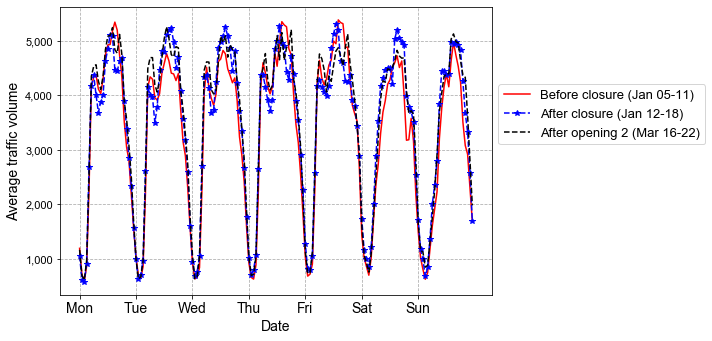

<Figure size 960x640 with 0 Axes>

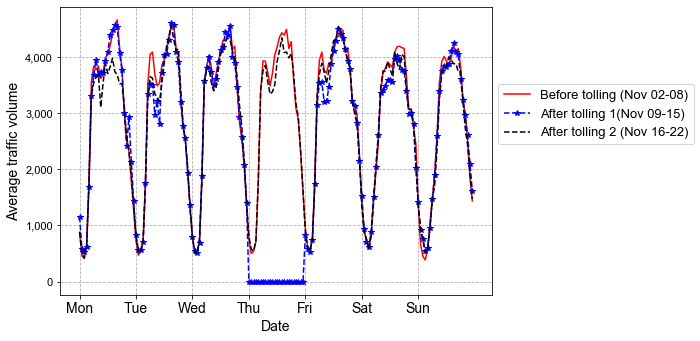

<Figure size 960x640 with 0 Axes>

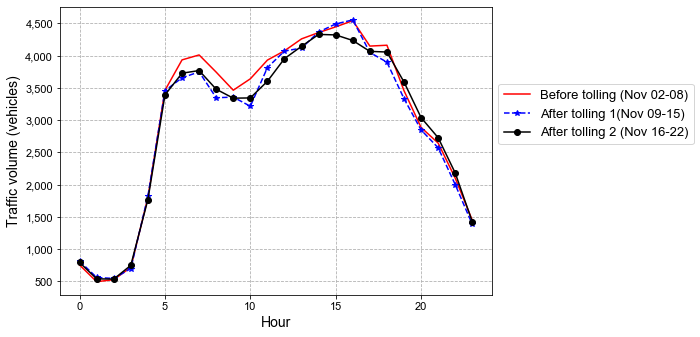

<Figure size 960x640 with 0 Axes>

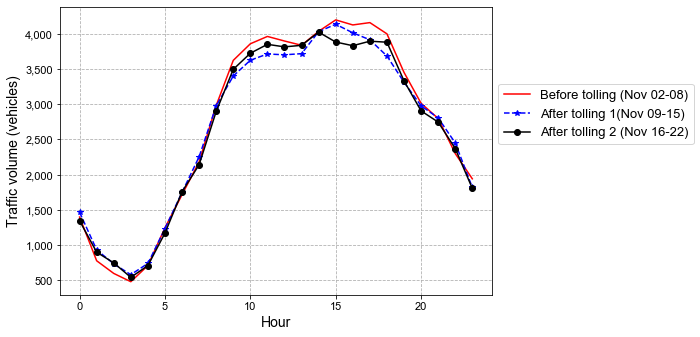

<Figure size 960x640 with 0 Axes>

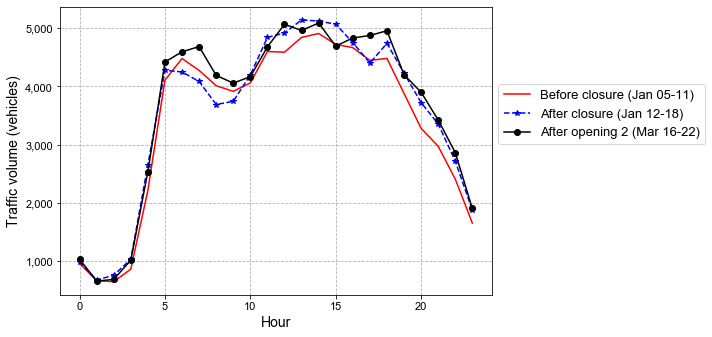

<Figure size 960x640 with 0 Axes>

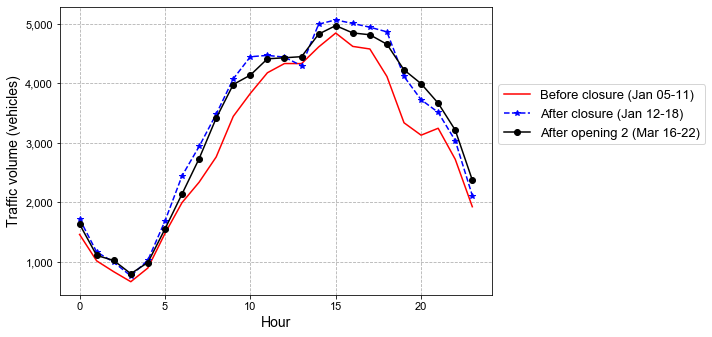

In [5]:
# run examples
p1 = '../acbcao/'
date1 = datetime(2019,1,5,0,0)
date2 = datetime(2019,3,22,0,0)
raw_data_process(p1, date1, date2)

p2 = '../atbt/'
date1 = datetime(2019,11,2,0,0)
date2 = datetime(2019,11,22,0,0)
raw_data_process(p2, date1, date2)

# check if data is available based on the time of interest
# and delete all the missing data
#bc period
bc1 = datetime(2019, 1, 5, 0, 0)
bc2 = datetime(2019, 1, 11, 0, 0)
#ac period
ac1 = datetime(2019, 1, 12, 0, 0)
ac2 = datetime(2019, 1, 18, 0, 0)
#ao2 period
ao21 = datetime(2019, 3, 16, 0, 0)
ao22 = datetime(2019, 3, 22, 0, 0)
#bt
bt1 = datetime(2019,11,2,0,0)
bt2 = datetime(2019,11,8,0,0)
#at1
at11 = datetime(2019,11,9,0,0)
at12 = datetime(2019,11,15,0,0)
#at2
at21 = datetime(2019,11,16,0,0)
at22 = datetime(2019,11,22,0,0)

acbcao = ['BC','AC','AO2']
atbt = ['BT','AT1','AT2']

# for acbcao
# get current available .xlsx file      
loop_vol1 = makeloopvol(acbcao, p1)
acbcao_bond = [bc1, bc2, ac1, ac2, ao21, ao22]

# for atbt
loop_vol2 = makeloopvol(atbt, p2)
atbt_bond = [bt1, bt2, at11, at12, at21, at22]

#acbcao
loop_vol1 = excel_processing(p1, acbcao, acbcao_bond, loop_vol1)
loc1 = get_loop_location(loop_vol1, p1)
#atbt
loop_vol2 = excel_processing(p2, atbt, atbt_bond, loop_vol2)
loc2 = get_loop_location(loop_vol2, p2)

# Daily
# weekday
WeekAvg, DayAvg = CalVol(loop_vol1, 0, 24, 1, 3)
# weekend
WeekAvg_kd, DayAvg_kd = CalVol(loop_vol1, 0, 24, 5, 6)

# morning peak 6:00 am - 10:00 am 
# weekday
WeekAvg_mor, DayAvg_mor = CalVol(loop_vol1, 6, 11, 1, 3)
# weekend
WeekAvg_mor_kd, DayAvg_mor_kd = CalVol(loop_vol1, 6, 11, 5, 6)

# evening peak 3:00 pm - 7:00 pm (15:00 - 19:00)
# weekday
WeekAvg_eve, DayAvg_eve = CalVol(loop_vol1, 15, 20, 1, 3)
# weekend
WeekAvg_eve_kd, DayAvg_eve_kd = CalVol(loop_vol1, 15, 20, 5, 6)

#calculate average hourly traffic volume
AvgLPhr,AvgHr = CalHourAvg(loop_vol1, 0, 6, ['N','S'], ['005','099'])
AvgLPhr_wd_acbc,AvgHr_wd_acbc = CalHourAvg(loop_vol1, 1, 3, ['N','S'], ['005','099'])
AvgLPhr_wk_acbc,AvgHr_wk_acbc = CalHourAvg(loop_vol1, 5, 6, ['N','S'], ['005','099'])
AvgLPhr_wd_atbt,AvgHr_wd_atbt = CalHourAvg(loop_vol2, 1, 3, ['N','S'], ['005','099'])
AvgLPhr_wk_atbt,AvgHr_wk_atbt = CalHourAvg(loop_vol2, 5, 6, ['N','S'], ['005','099'])

# daily avg based on all loops
alldayAvg = CalallDayAvg(DayAvg)
alldayAvg_mor = CalallDayAvg(DayAvg_mor)
alldayAvg_eve = CalallDayAvg(DayAvg_eve)

# make legend for AC period, BC period and AO period
lgacbcao = ['Before closure (Jan 05-11)','After closure (Jan 12-18)','After opening 2 (Mar 16-22)']
# make legend for AT period, BT period
lgatbt = ['Before tolling (Nov 02-08)','After tolling 1(Nov 09-15)','After tolling 2 (Nov 16-22)']

# plot hourly average
p = 'G:/My Drive/2020/FHWA/FHWA_2020_plot/Loop/'
plothr(lgacbcao, loop_vol1, p+'acbc_daily_avg.jpg')
plothr(lgatbt, loop_vol2, p+'atbt_daily_avg.jpg')
#tidedictandplot(AvgHr, '')
hourlyplot(AvgHr_wd_atbt, ' (weekday)', lgatbt, p+'atbt_hr_avg_wd.jpg')
hourlyplot(AvgHr_wk_atbt, ' (weekend)', lgatbt, p+'atbt_hr_avg_wk.jpg')
hourlyplot(AvgHr_wd_acbc, ' (weekday)', lgacbcao, p+'acbc_hr_avg_wd.jpg')
hourlyplot(AvgHr_wk_acbc, ' (weekend)', lgacbcao, p+'acbc_hr_avg_wk.jpg')

In [9]:
1-1/5-8/25-36/125-96/625

0.03840000000000007

In [17]:
a = 0
for i in range(9):
    if i == 0:
        a = (i+1)/10
    else:
        b = 1
        for j in range(i):
            b = b*(9-j)/10
         #   print(b)
        #print('last', (i+1)/10)
        b = b*(i+1)/10
        a = a+b
print(1-a)

0.00036287999999995435
